# ICT nudging pipelines notebook

## Introduction

This notebook is part of a series of notebooks presenting the numerical simulations, and the results, for the article **"Realistic Nudging through ICT Pipelines to Help Improve Energy Self-Consumption for Management in Energy Communities".**

### General description

Our model comprises two parts:

1. a **simulated part** which simulates an household consuming energy, and reacting to nudges.

2. a **real world part** which contains the true algorithms processing the available information, and constructing the nudges.

The scheme below shows the various parts of our model. The real world algorithms are plugged on the simulated part, but they can be unplugged, and plugged into the "real world".

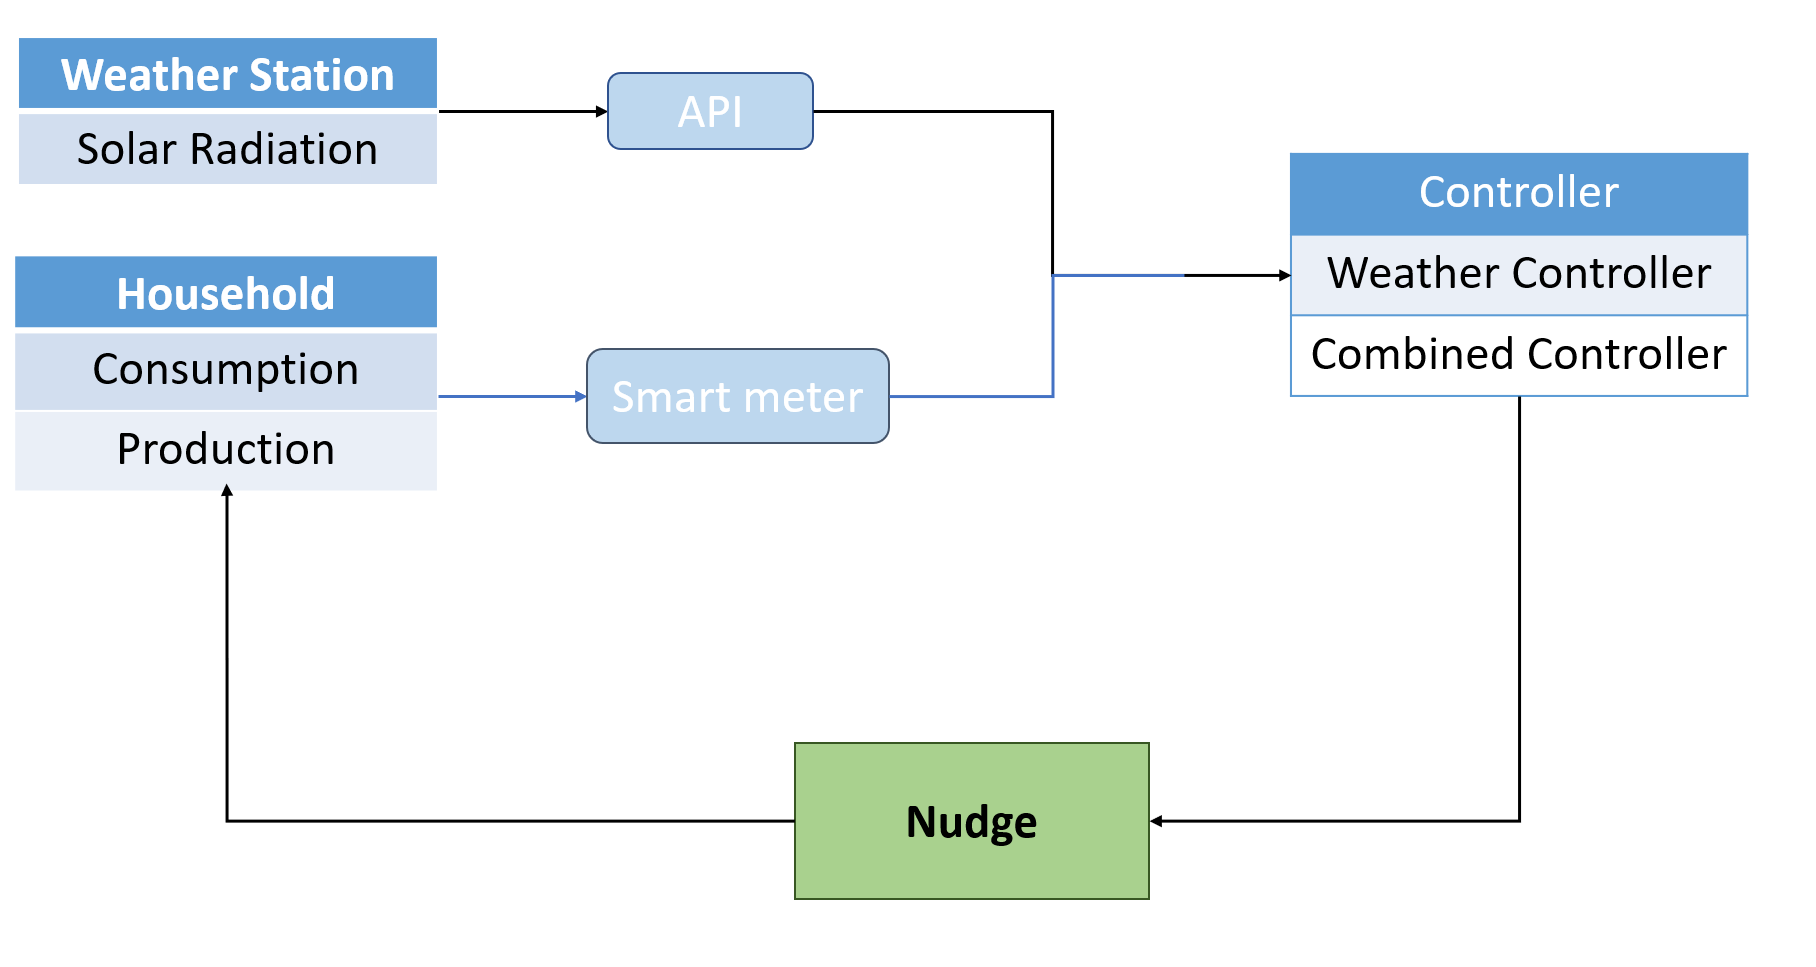

In [1]:
from IPython.display import Image
Image(filename='NudgingPipeline.PNG') 

### Case study 

The numerical simulations presented in **Section 4.5.** illustrate the efficiency of our nudging pipelines in improving the self-sufficiency, and self-consumption rates of the real household.

Our case study is conducting on a real data set Iris dataset. **The Iris dataset** is a collection of residential energy consumption data from **98 houses** spanning a period of **one year**, and is a **subset** of a **European database** gathered as part of the **REMODECE project**.

In this study, we conducted extensive simulations using the Iris dataset to demonstrate the performance of our controllers on a real-world dataset.

<font color="red">We are unable to provide the Iris Dataset for this notebook due to licensing restrictions. However, you can still use this notebook by providing your own dataset to run the simulations. Make sure to set the timeline parameters of your new dataset for the simulation.</font>

## Setting-up the model and the simulation parameters

We first obtain the absolute path of the current working directory, and import some utils modules.

In [2]:
import pandas as pd
import os
path = os.path.abspath(os.path.dirname(os.getcwd()))
path = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(path)
from src.utils import set_simulation_config as sconf
from src.utils import util_functions as ut
import utils_notebook as ub

### Set simulation parameters

The simulation depends on various parameters, related to the different aspects of the model, in the simulated world, and the real world algorithms.

In the **simulated world**, we have:

1. the **household**;


2. the **solar pannels**;


3. the **general simulation settings.**

The **real world algorithms** are
1. the **controllers** (algorithms which process information and send nudges to the household).

**There are several parameters in the simulation configuration whose values we have fixed**,and for more information, please refer to the notebook "[simple example](https://gitlab.enogrid.ovh/recherche-et-d-veloppement/ml_for_nudging/-/blob/open_source/Notebook_Exemple/Simple_example.ipynb "Go to Example notebook").". 


We define below the main parameters, and briefly comment on them.

### Household settings - Get all data location

Here, all that is required is to get the location of the all household data. For each data file we determine the shiftable and non-shiftable profiles.

In [3]:
path  = "C:\\Users\\lingh\\projet_enogrid\\projet_acc\\ml_nudge_acc\\data\\inputs\\iris" ## add your own dataset directory
all_file_path = ut.get_all_file_path_in_one_dir(path)

###  Solar pannels
The variable **coeff_sunshine_to_prod** represents the capacity, in Watts, of the solar pannels (that is, their production when sunshine is at its maximum).

Please refer to the notebook for explanations about this choice ["Influence of the Amount of Production"](https://gitlab.enogrid.ovh/recherche-et-d-veloppement/ml_for_nudging/-/blob/py_notebooks/Notebook_Exemple/Influence%20of%20the%20Amount%20of%20Production%20.ipynb) and refer to the **Section 4.6.** in our paper.

In [4]:
coeff_shunshin_to_prode = [1900]

During the simulation, we compute synthetic sunshine coefficients. They depend on the time of day, the month of year, and the level of clouds. The sequence of clouds is modelled as a Markov Chain. It is therefore stochastic.

### Controllers settings


We set parameters for our two controllers: Weather Controller, and Combined Controller.

1. **nb_periods_max** : This parameter sets the maximum number of **green periods** labelled by a nudge,The default value is 4. It's a parameter for both Controller and we did a study for illustrating the influence of the number of green periods on a simulation. For more information please refer to the notebook ["Influence of the Number of Green Periods"](https://gitlab.enogrid.ovh/recherche-et-d-veloppement/ml_for_nudging/-/blob/open_source/Notebook_Exemple/Influence%20of%20the%20Number%20of%20Green%20Periods.ipynb) and refer to the **Section 4.7.** in our paper.


2. **predictor_type** : this parameter specifies the type of energy forecasting model to use for the Combined Controller. There are two options: a "simple" model (using as consumption prediction past consumption averages for each day, and each 30 minutes time slot), and a "Random Forest" model.

In [5]:
nb_periods_max = [4]
predictor_type = "simple"

### General Simulation Settings

Here are some important general parameters for the simulation:

1. **Timeline Data** :The timeline data is used to define both the historical data (**historical_data_begin** and **historical_data_end**) for training energy forecasting models and the simulation data(**begin_simulation** and **length_of_simulation**) for nudging simulations. 


2. **nb_runs** : The number of simulation runs.



3. **run_optimisation** : If **True**, compare the simulation results obtained from the nudge algorithm with the results obtained from the optimization algorithm calculated by OMEGalpes. **OMEGAlpes** is **a linear optimization tool** designed to easily generate multi-carrier energy system models. Its purpose is to assist in developing district energy projects by integrating design and operation in pre-studies phases. For more informations, please refer to [OMEGalpes](https://omegalpes.readthedocs.io/en/stable/about_OMEGAlpes.html)


In [6]:
nb_runs = 3
run_optimisation = True
historical_data_begin = "04/09/2019"
historical_data_end = "10/07/2019" 
begin_simulation = "10/13/2019"
length_of_simulation = 33

## Metrics studied


1. **Self_consumption rate**: it refers to the percentage of the electricity generated by a renewable energy system that is consumed on-site by the system owner, rather than being exported to the grid. 


2. **self_sufficiency rate**: it refers to the proportion of electricity that is generated by an energy source and consumed on-site, relative to the total electricity consumption of the site.


**For more informations, please refer to Section 3.2. of our paper.**

## Create a timeout function

Occasionally, we encounter issues with infeasible optimization or optimization that fails to converge. To prevent these problems, we have implemented a timeout function that interrupts the optimization if it takes longer than 30 minutes to complete.

In [7]:
from func_timeout import func_set_timeout, FunctionTimedOut
@func_set_timeout(1800)  ## set timeout for 30min
def mytest2():
    simconf = sconf.SimulationConfig(file,
                                    predictor_type=predictor_type,
                                    historical_data_begin=historical_data_begin,
                                    historical_data_end=historical_data_end,
                                    begin_simulation=begin_simulation,
                                    length_of_simulation=length_of_simulation)
    sim = sconf.RunSimulation(
        simconf,
        run_optimisation=run_optimisation,
        nb_runs=nb_runs,
        nb_periods_max=nb_periods_max,
        coeff_sunshine=coeff_shunshin_to_prode,
    )
    result = sim.run_simulation()
    
    return result

## Running simulations

We now run our simulations, with the parameters we have defined.

In [ ]:
all_result = pd.DataFrame()
for file in all_file_path:
    try:
        result = mytest2()
        all_result = pd.concat([all_result,result],axis=1)
    except:
        continue

## Visualisation

In addition to our two controllers, we present the following two results:

- Reference : The **absence of nudging** serves as the **lower bound** in terms of reference.


- Omegalpes : It represents an **optimization approach** aimed at **maximizing the self-consumption/production rate**. It provides a performance **upper bound**. It uses unrealistic information (detailed dissagregated knowledge of the future consumption), and thus cannot be used as a nudging algorithm.

### Self_consumption rate
We first study the self-consumption rate.


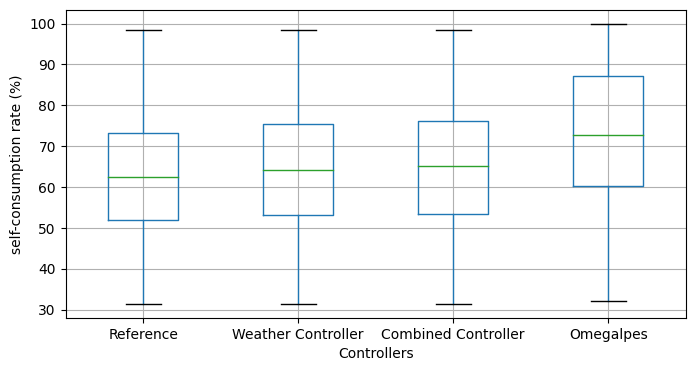

In [9]:
self_consumption_rate_result = ub.visualisation_results_of_all_simulations(all_result,'consumption')

We see that both our controllers improve the self-consumption rate, with respect to the Reference case. Detailed values are provided below.

In [10]:
self_consumption_rate_result.mean()

Reference              62.214311
Weather Controller     63.787969
Combined Controller    64.231131
Omegalpes              72.253659
dtype: float64

We can visualise these average values as a bar plot.

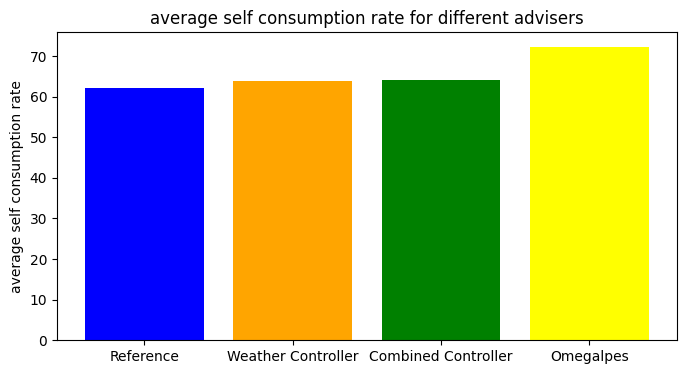

In [11]:
ub.average_result_visualisation(self_consumption_rate_result.mean(),'consumption')

### self-sufficiency rate
Now, we study the self-sufficiency rate

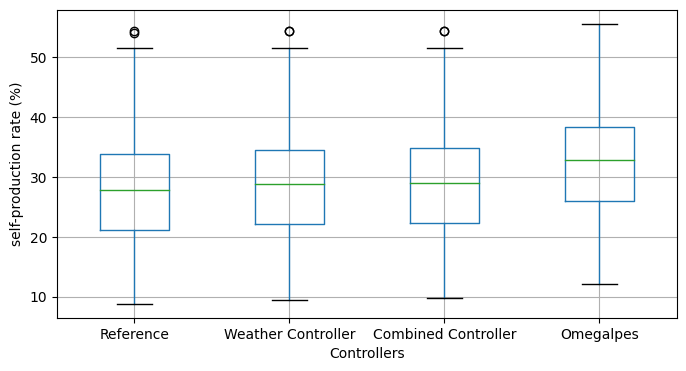

In [12]:
self_sufficiency_rate_result = ub.visualisation_results_of_all_simulations(all_result,'production')

We see that both our controllers improve the self-sufficiency rate, with respect to the Reference case. Detailed values are provided below.

In [13]:
self_sufficiency_rate_result.mean()

Reference              28.070176
Weather Controller     28.748520
Combined Controller    28.932588
Omegalpes              32.161022
dtype: float64

We can visualise these average values as a bar plot.

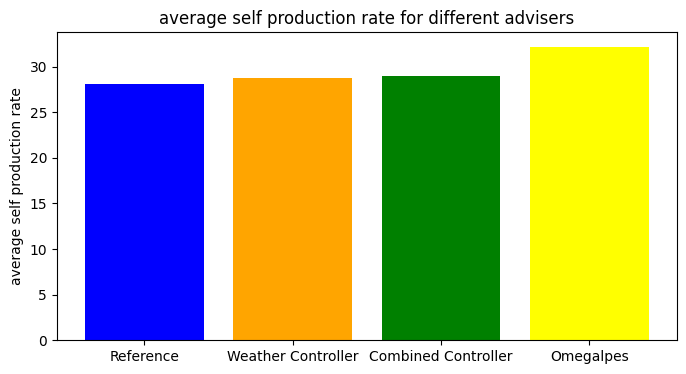

In [14]:
ub.average_result_visualisation(self_sufficiency_rate_result.mean(),'production')

## Improvement ratio : the improvement by different controller compare with the improvement of omegalpes


We compute the improvement ratio of different controllers compared to Omegalpes using the equations: 

$$ Ratio\_WeatherController =\frac{\text{self_consumption_rate}_{weather} - \text{self_consumption_rate}_{\text{reference}}}{\text{self_consumption_rate}_{Omegalpes} - \text{self_consumption_rate}_{reference}} $$

$$ Ratio\_CombinedController =\frac{\text{self_consumption_rate}_{combined} - \text{self_consumption_rate}_{reference}}{\text{self_consumption_rate}_{Omegalpes} - \text{self_consumption_rate}_{reference}} $$

The improvement ratios calculated using self-consumption rate and self-sufficiency rate are identical. Therefore, we will calculate the improvement ratio using only the self-consumption rate.

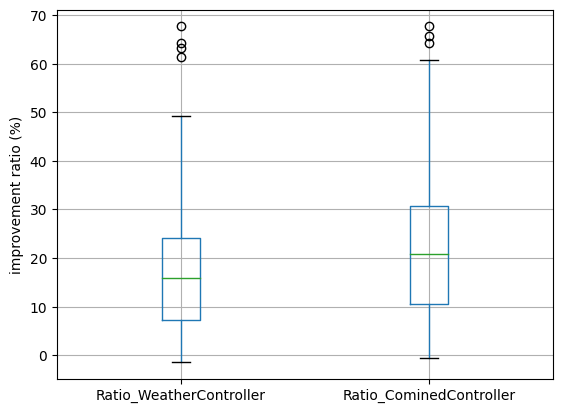

In [15]:
ratio = ub.calculate_improvement_ratio (self_consumption_rate_result)

## Average improvement ratio

In [16]:
ratio.mean()

Ratio_WeatherController    17.224996
Ratio_CominedController    21.596377
dtype: float64

## Conclusion

We see that on average, the Weather and Combined controllers improve the **self-consumption rate** by
**2%**. This corresponds to roughly **20% of the OMEGalpes performance**. While the results of OMEGalpes are much
higher than that of the controllers, we believe it is mainly due to the limitless number of shifts in consumption it can perform,
and to the fact it uses per-appliance knowledge of the true consumption. Therefore, given these advantages, we believe
reaching 20% of its performance still shows a reasonable efficiency of our nudging pipelines.